# Calculadora de Opções

Para usar a calculadora, é só clicar me "run all" e ir preenchendo as caixas de texto que aparecerem

A calculadora possui os mecanismos descritos na célula de funções, sendo os principais os seguintes recursos:
- Simulação de Monte Carlo (mc_normal) para simular a série de preço de um ativo.
- Precificação de Opção Europeia (euro_vanilla_call) para precificar uma Call.
- Precificação de Opção Europeia (euro_vanilla_put) para precificar uma Put.
- Precificação de Call ou Put de uma Opção Exótica (exotica) em que o preço de exercício é calculado pela média dos preços dos últimos 5 dias.
- Precificação de Opção Binária (binaria)

Obs: A calculadora importa os dados através da API do Yahoo Finance e do Banco Central através de algumas funções. A conexão com a internet é necessária.

### Importar Libs

In [1]:
import yfinance as yf
import math
import matplotlib.pyplot as plt
import numpy as np
from time import time
import pandas as pd
from datetime import date
import scipy.stats
plt.style.use('dark_background')
%matplotlib inline

### Funções

In [2]:
def consulta_bc(codigo_bcb):
    '''
    Importa os dados Banco Central através de uma API
    '''
    url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
    df = pd.read_json(url)
    df['data'] = pd.to_datetime(df['data'], dayfirst=True)
    df.set_index('data', inplace=True)
    return df


def calcula_retornos(data: pd.Series, column="Close"):
    '''
    Calcula o retorno acumulado da série
    '''
    df = data[column].pct_change()
    df.drop(df.head(1).index,inplace=True)
    
    return pd.DataFrame(df)


def cornish (r: pd.Series, z):
    '''
    Função para adptar o z com a ampliação de cornish-fisher
    '''
    s = scipy.stats.skew(r)
    k = scipy.stats.kurtosis(r)
    z = (z +
            (z**2 - 1)*s/6 +
            (z**3 -3*z)*(k-3)/24 -
            (2*z**3 - 5*z)*(s**2)/36
        )
    return z


def is_normal(r, level=0.01):
    """
    Utiliza o Jarque-Bera test para determinar se a distribuição é normal ou não
    O nível de confiança é de 1%, podendo mudar seu parâmetro
    Retorna verdadeiro se a hipotese de normalidade é verdadeira
    """
    statistic, p_value = scipy.stats.jarque_bera(r)
    return p_value > level


def mc_normal(data, S0 = -1, K = -1, T = 1.0, r = -1, M = -1, I = -1, retornar = -1):
    '''
    Retorna um DataFrame com as simulações de Monte Carlo
    Ou mesmo o valor de uma opção europeia
    
    Adaptado de Pricing a European Call Option Using Monte Carlo Simulation por Nícolas Mikio
    https://www.datasciencecentral.com/profiles/blogs/pricing-options-using-monte-carlo-simulations
    https://sphelps.net/teaching/fpmf/slides/all.html
    '''
    if S0 == -1:
        S0 = float(input("Qual o preço da ação? "))
        
    if K == -1:
        K = float(input("Qual o preço de exercício? "))
        
    if M == -1:
        M = int(input("Para quantos períodos de tempo? "))
        
    if I == -1:
        I = int(input("Quantas simulações? "))
        
    if r == -1:  
        cdi = consulta_bc(12)
        cdi_recente = cdi.iloc[-1]
        r = (1 + cdi_recente/100).prod()**(252)-1
        #Transformação em taxa composta anualmente
        r = math.log(r+1)
        
    sigma = data.std()*(252**0.5)
    sigma = sigma[0]
    
    #Usar a função is_normal para verificar com o teste de Jarque-Bera se a distribuição dos retornos é normal
    #Caso a distribuição NÃO for normal, então usamos a ampliação de cornish-fisher para adaptar o z:
    if is_normal(data) == False:
        S = S0 * np.exp(np.cumsum((r - 0.5 * sigma ** 2) * (T/M) + sigma * math.sqrt(T/M) * 
                                  cornish(data, np.random.standard_normal((M + 1, I))), axis=0))
        
    #Caso a distribuição for normal, então:
    else:
        S = S0 * np.exp(np.cumsum((r - 0.5 * sigma ** 2) * (T/M) + sigma * math.sqrt(T/M) * 
                                  np.random.standard_normal((M + 1, I)), axis=0))
    
    if retornar == -1:
        retornar = int(input("DataFrame = 1, call = 2 ou put = 3? "))
    
    if retornar == 1:
        return  pd.DataFrame(S)
    
    if retornar == 2:
        return math.exp(-r * T) * sum(np.maximum(S[-1] - K, 0)) / I
    
    if retornar == 3:
        return math.exp(-r * T) * sum(np.maximum(K - S[-1], 0)) / I


def euro_vanilla_call(data, S=-1, K=-1, T=-1, r=-1):
    '''
    Precifica uma opção de call europeia, com base nos argumentos fornecidos:
    (data, S= spot price, K= strike price, T= time to maturity, r= interest rate).
    
    Os argumentos podem ser digitados no input, ou mesmo incluídos dentro da função.
    
    É utilizado a ampliação de cornish-fisher para corrigir o valor z atribuído pelas argumentos d1 e d2
    
    A taxa livre de risco dada como default pela função é a o CDI acumulado anual dos anos 2020 a 2021,
    porém pode ser modificada na função ao escrever:
    euro_vanilla_call(data, r= valor_da_taxa)
    '''
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    if S == -1:
        S = float(input("Qual o preço da ação? "))
        
    if K == -1:
        K = float(input("Qual o preço de exercício? "))
        
    if T == -1:
        T = int(input("Quantos períodos até a data de expiração? "))
        T = T/252
        
    if r == -1:  
        cdi = consulta_bc(12)
        cdi_recente = cdi.iloc[-1]
        r = (1 + cdi_recente/100).prod()**(252)-1
        #Transformação em taxa composta anualmente
        r = math.log(r+1)
    
    #volatilidade (desvio padrao) anualizado
    sigma = data.std()*(252**0.5)
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    d1 = cornish(data, d1)
    d2 = cornish(data, d2)
    
    call = (S * scipy.stats.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * scipy.stats.norm.cdf(d2, 0.0, 1.0))
    
    return call[0].round(2)


def euro_vanilla_put(data, S=-1, K=-1, T=-1, r=-1):
    
    '''
    Precifica uma opção de put europeia, com base nos argumentos fornecidos:
    (data, S= spot price, K= strike price, T= time to maturity, r= interest rate).
    
    Os argumentos podem ser digitados no input, ou mesmo incluídos dentro da função.
    
    É utilizado a ampliação de cornish-fisher para corrigir o valor z atribuído pelas argumentos d1 e d2
    
    A taxa livre de risco dada como default pela função é a o CDI acumulado anual dos anos 2020 a 2021,
    porém pode ser modificada na função ao escrever:
    euro_vanilla_call(data, r= valor_da_taxa)
    '''
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    if S == -1:
        S = float(input("Qual o preço da ação? "))
        
    if K == -1:
        K = float(input("Qual o preço de exercício? "))
        
    if T == -1:
        T = int(input("Quantos períodos até a data de expiração? "))
        T = T/252
        
    if r == -1:  
        cdi = consulta_bc(12)
        cdi_recente = cdi.iloc[-1]
        r = (1 + cdi_recente/100).prod()**(252)-1
        #Transformação em taxa composta anualmente
        r = math.log(r+1)
    
    #volatilidade (desvio padrao) anualizado
    sigma = data.std()*(252**0.5)
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    d1 = cornish(data, d1)
    d2 = cornish(data, d2)
    
    put = (K * np.exp(-r * T) * scipy.stats.norm.cdf(-d2, 0.0, 1.0) - S * scipy.stats.norm.cdf(-d1, 0.0, 1.0))
    
    return put[0].round(2)


def exotica(data, S0 = -1, K = -1, T = 1.0, r = -1, M = -1, I = -1, retornar = -1):
    '''
    Retorna um DataFrame com as simulações de Monte Carlo, ou mesmo o valor de uma opção exótica
    em que o preço final é a média dos últimos 5 dias úteis    
    '''
    if S0 == -1:
        S0 = float(input("Qual o preço da ação? "))
        
    if K == -1:
        K = float(input("Qual o preço de exercício? "))
        
    if M == -1:
        M = int(input("Para quantos períodos de tempo? "))
        
    if I == -1:
        I = int(input("Quantas simulações? "))
        
    if r == -1:  
        cdi = consulta_bc(12)
        cdi_recente = cdi.iloc[-1]
        r = (1 + cdi_recente/100).prod()**(252)-1
        #Transformação em taxa composta anualmente
        r = math.log(r+1)
        
    sigma = data.std()*(252**0.5)
    sigma = sigma[0]
    
    #Usar a função is_normal para verificar com o teste de Jarque-Bera se a distribuição dos retornos é normal
    #Caso a distribuição NÃO for normal, então usamos a ampliação de cornish-fisher para adaptar o z:
    if is_normal(data) == False:
        S = S0 * np.exp(np.cumsum((r - 0.5 * sigma ** 2) * (T/M) + sigma * math.sqrt(T/M) * 
                                  cornish(data, np.random.standard_normal((M + 1, I))), axis=0))
        
    #Caso a distribuição for normal, então:
    else:
        S = S0 * np.exp(np.cumsum((r - 0.5 * sigma ** 2) * (T/M) + sigma * math.sqrt(T/M) * 
                                  np.random.standard_normal((M + 1, I)), axis=0))
    
    if retornar == -1:
        retornar = int(input("DataFrame = 1, call = 2 ou put = 3? "))
    
    S = pd.DataFrame(S)
    
    if retornar == 1:
        return S
    
    if retornar == 2:
        return math.exp(-r * T) * sum(np.maximum(S.iloc[-6:-1].mean() - K, 0)) / I
    
    if retornar == 3:
        return math.exp(-r * T) * sum(np.maximum(K - S.iloc[-6:-1].mean(), 0)) / I
    
    
    
def binaria(data, S0 = -1, K = -1, recompensa =-1, T = 1.0, r = -1, M = -1, I = -1, retornar = -1):
    '''
    Retorna o preço de uma opção exótica binária    
    '''
    if S0 == -1:
        S0 = float(input("Qual o preço da ação? "))
        
    if K == -1:
        K = float(input("Qual o preço de exercício? "))
    
    if recompensa == -1:
        recompensa = float(input("Qual o valor da recompensa? "))
        
    if M == -1:
        M = int(input("Para quantos períodos de tempo? "))
        
    if I == -1:
        I = int(input("Quantas simulações? "))
        
    if r == -1:  
        cdi = consulta_bc(12)
        cdi_recente = cdi.iloc[-1]
        r = (1 + cdi_recente/100).prod()**(252)-1
        #Transformação em taxa composta anualmente
        r = math.log(r+1)
        
    sigma = data.std()*(252**0.5)
    sigma = sigma[0]
    
    #Usar a função is_normal para verificar com o teste de Jarque-Bera se a distribuição dos retornos é normal
    #Caso a distribuição NÃO for normal, então usamos a ampliação de cornish-fisher para adaptar o z:
    if is_normal(data) == False:
        S = S0 * np.exp(np.cumsum((r - 0.5 * sigma ** 2) * (T/M) + sigma * math.sqrt(T/M) * 
                                  cornish(data, np.random.standard_normal((M + 1, I))), axis=0))
        
    #Caso a distribuição for normal, então:
    else:
        S = S0 * np.exp(np.cumsum((r - 0.5 * sigma ** 2) * (T/M) + sigma * math.sqrt(T/M) * 
                                  np.random.standard_normal((M + 1, I)), axis=0))
    
    if retornar == -1:
        retornar = int(input("higher = 1 ou lower = 2? "))

    #Higher
    if retornar == 1:
        payoffs = np.sum(S[-1] > K)

    #Lower
    if retornar == 2:
        payoffs = np.sum(S[-1] < K)

    option_price = math.exp(-r * T) * (payoffs / I) * recompensa
    
    return option_price

In [3]:
df = str(input("Qual ativo analisar? Ex. digite ITSA4.SA  "))

data = yf.download(df, start="2015-01-01")
display(data)

Qual ativo analisar? Ex. digite ITSA4.SA  ITSA4.SA
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,6.969978,7.036998,6.791261,6.828494,4.723387,14567668
2015-01-05,6.724242,6.955085,6.687009,6.850834,4.738839,27743553
2015-01-06,6.865727,6.925299,6.768921,6.902959,4.774894,45486782
2015-01-07,7.036998,7.267841,7.022104,7.163589,4.955177,26784452
2015-01-08,7.223161,7.282734,7.051891,7.238055,5.006687,21225106
...,...,...,...,...,...,...
2021-03-26,10.180000,10.380000,10.170000,10.360000,10.360000,21252500
2021-03-29,10.280000,10.390000,10.170000,10.320000,10.320000,18395500
2021-03-30,10.270000,10.470000,10.270000,10.470000,10.470000,22484400


<AxesSubplot:title={'center':'Série Temporal Cotações'}, xlabel='Date'>

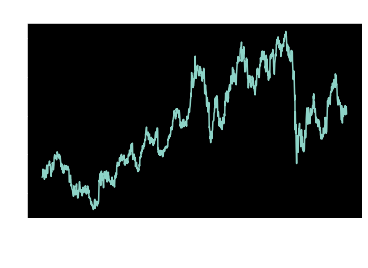

In [4]:
data["Close"].plot(title= 'Série Temporal Cotações')

In [5]:
#DataFrame com os Retornos
x = calcula_retornos(data)
x

,Close
Date,
2015-01-05,0.003272
2015-01-06,0.007609
2015-01-07,0.037756
2015-01-08,0.010395
2015-01-09,-0.034979
...,...
2021-03-26,0.009747
2021-03-29,-0.003861
2021-03-30,0.014535


<AxesSubplot:title={'center':'Série Temporal dos Retornos'}, xlabel='Date'>

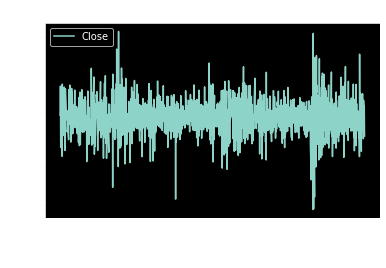

In [6]:
x.plot(title = "Série Temporal dos Retornos")

array([[<AxesSubplot:title={'center':'Close'}>]], dtype=object)

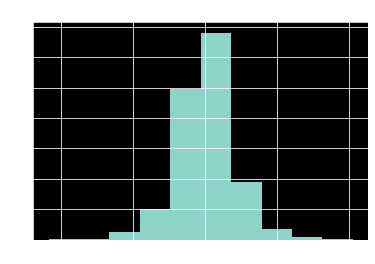

In [7]:
#Histograma dos Retornos
x.hist()

In [8]:
x.describe()

,Close
count,1547.000000
mean,0.000463
std,0.020491
min,-0.108654
25%,-0.011325
50%,0.000000
75%,0.011908
max,0.102696


### Simula Preço de Ativos (preencher caixa de texto)

Qual o preço da ação? 10
Qual o preço de exercício? 12
Para quantos períodos de tempo? 100
Quantas simulações? 10000
DataFrame = 1, call = 2 ou put = 3? 1


,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,9.724175,9.856067,10.308100,9.830543,9.435905,10.217921,9.644605,9.931511,9.504498,9.761438,...,10.267772,10.348219,9.572046,9.268356,10.123203,10.035444,10.316008,10.059102,10.155258,10.291734
1,9.657031,9.866834,10.154559,9.664548,9.710761,10.085778,9.714745,9.902878,9.249152,9.360645,...,10.338749,10.778529,9.400290,9.340636,10.230117,9.423841,10.428456,9.910871,9.750381,10.060508
2,9.733804,9.815256,10.316893,9.150974,9.470148,9.990956,10.142712,9.853033,9.124956,9.049136,...,10.526405,11.128867,9.376044,9.666091,10.053919,9.260898,10.575077,9.188641,9.666050,9.877908
3,9.446252,9.870102,9.893199,9.395779,9.583225,10.250242,10.355472,10.243530,9.298821,9.306168,...,9.990574,11.748072,8.835369,9.732975,10.493188,9.251945,10.709041,8.844083,10.289436,9.432304
4,9.575707,10.190821,9.905183,9.128918,9.780236,10.007451,9.610196,9.790299,9.168422,9.553786,...,10.031215,11.921931,8.876495,9.332280,10.304889,9.633275,10.076809,9.037711,10.410728,9.530669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,9.522183,9.240043,8.751079,11.447800,11.311775,10.804855,7.133668,9.180418,21.244859,8.372052,...,15.792936,7.646989,9.355786,10.538931,14.141131,8.342105,6.364667,9.714292,17.566125,10.707904
97,9.435690,9.011148,8.882382,11.639394,11.223367,10.911530,7.418414,9.060290,21.182617,8.386934,...,15.469916,7.474396,9.126707,10.508834,13.801060,8.707568,6.101829,9.863673,17.445022,9.989250
98,9.856867,8.901285,8.852144,11.660592,11.921456,10.825194,7.745045,8.789057,22.243342,8.193622,...,15.400316,7.660450,9.097650,10.887993,12.784529,8.783669,5.618618,10.230920,17.474115,10.134766
99,9.970378,9.198002,8.499684,11.619980,11.521164,11.124655,7.834024,8.765321,22.271334,7.931798,...,15.009712,8.124105,9.081888,10.596961,12.714820,9.206951,5.494753,10.064105,18.223697,10.015490


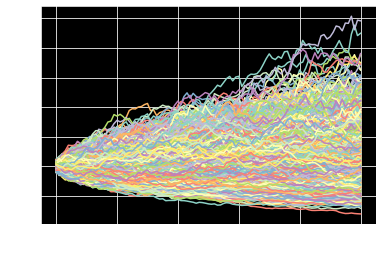

In [9]:
S = mc_normal(x)
display(S)
plt.plot(S)
plt.grid(True)
plt.xlabel('Steps')
plt.ylabel('Valor $')
plt.show()

### Precifica Call Europeia por BS (preencher caixa de texto)

In [10]:
o = euro_vanilla_call(x)
o

Qual o preço da ação? 10
Qual o preço de exercício? 12
Quantos períodos até a data de expiração? 100


0.27

### Precifica Put Europeia por BS (preencher caixa de texto)

In [11]:
o = euro_vanilla_put(x)
o

Qual o preço da ação? 10
Qual o preço de exercício? 10
Quantos períodos até a data de expiração? 100


0.77

### Precifica Call Exótica por MC - Preço final igual a média dos últimos 5 dias (preencher caixa de texto)

In [12]:
exotica(x, retornar = 2)

Qual o preço da ação? 10
Qual o preço de exercício? 12
Para quantos períodos de tempo? 100
Quantas simulações? 100000


0.6962523095945676

### Precifica Put Exótica por MC - Preço final igual a média dos últimos 5 dias (preencher caixa de texto)

In [13]:
exotica(x, retornar = 3)

Qual o preço da ação? 10
Qual o preço de exercício? 10
Para quantos períodos de tempo? 100
Quantas simulações? 100000


1.1311141396377928

### Precifica Higher Binária (preencher caixa de texto)


In [14]:
binaria(x, retornar = 1)

Qual o preço da ação? 10
Qual o preço de exercício? 12
Qual o valor da recompensa? 1000
Para quantos períodos de tempo? 252
Quantas simulações? 100000


254.35004614537982

### Precifica Lower Binária (preencher caixa de texto)

In [15]:
binaria(x, retornar = 2)

Qual o preço da ação? 10
Qual o preço de exercício? 12
Qual o valor da recompensa? 1000
Para quantos períodos de tempo? 252
Quantas simulações? 100000


718.3837413479105